<h1>RMiniseedFile_Spec_Ana</h1>
<p>by Farnyuh Menq</p>
<p>NHERI@UTexas site Manager</p>
<p>2017/8/23</p>
<p>This notebook (1) open plot MiniSeed data files, (2) calculate and plot transfer function. </p>
<p>Ambient data colleceted from the Bridge Test is used in this notebook </p>
<p>obspy library provided by IRIS is used to read a MiniSEED file. More information regarding obspy module can be found at https://github.com/obspy/obspy/wiki</p>

In [1]:
# Import Library 
from pylab import *
import scipy
#import SglPrcFM_V2 as mf
from obspy import read # IRIS Python module for reading a MiniSEED file

## Load data and print out the contents of the data

In [2]:
folder = r'C:\Users\Farnyuh Menq\Desktop\Static\201708 NJ Bridge\Cox NJ Bridge\NJBridgeTrillium\Raw\31July2017'
folder = folder + '\\'
StartTime = '20170731_150000'
st_1 = read(folder + 'UT.STN01_' + StartTime + '.miniseed') #Ground surface, east pier, median
st_2 = read(folder + 'UT.STN02_' + StartTime + '.miniseed') #Ground surface, west pier, median
st_3 = read(folder + 'UT.STN03_' + StartTime + '.miniseed') #Ground surface, 85 ft west of west pier, median, free field
st_4 = read(folder + 'UT.STN04_' + StartTime + '.miniseed') #Deck, middle of bridge, above bent, west side
st_5 = read(folder + 'UT.STN05_' + StartTime + '.miniseed') #Deck, middle of bridge, above bent, east side

In [3]:
# st[0]: East, st[1]: vertical, st[2]: North - Note this order is not cosistent
print (st_1)
print (st_2)
print (st_3)
print (st_4)
print (st_5)
st =[st_1, st_2, st_3, st_4, st_5]
print (st[4][1].data)

3 Trace(s) in Stream:
UT.STN01..BHN | 2017-07-31T15:00:00.000000Z - 2017-07-31T15:59:59.990000Z | 100.0 Hz, 360000 samples
UT.STN01..BHZ | 2017-07-31T15:00:00.000000Z - 2017-07-31T15:59:59.990000Z | 100.0 Hz, 360000 samples
UT.STN01..BHE | 2017-07-31T15:00:00.000000Z - 2017-07-31T15:59:59.990000Z | 100.0 Hz, 360000 samples
3 Trace(s) in Stream:
UT.STN02..BHE | 2017-07-31T15:00:00.000000Z - 2017-07-31T15:59:59.990000Z | 100.0 Hz, 360000 samples
UT.STN02..BHN | 2017-07-31T15:00:00.000000Z - 2017-07-31T15:59:59.990000Z | 100.0 Hz, 360000 samples
UT.STN02..BHZ | 2017-07-31T15:00:00.000000Z - 2017-07-31T15:59:59.990000Z | 100.0 Hz, 360000 samples
3 Trace(s) in Stream:
UT.STN03..BHE | 2017-07-31T15:00:00.000000Z - 2017-07-31T15:59:59.990000Z | 100.0 Hz, 360000 samples
UT.STN03..BHZ | 2017-07-31T15:00:00.000000Z - 2017-07-31T15:59:59.990000Z | 100.0 Hz, 360000 samples
UT.STN03..BHN | 2017-07-31T15:00:00.000000Z - 2017-07-31T15:59:59.990000Z | 100.0 Hz, 360000 samples
3 Trace(s) in Stream:
UT.

In [4]:
N_Dir = [0, 1, 2, 1, 1] # list of channel data of North direction
E_Dir = [2, 0, 0, 2, 2] # list of channel data of East direction
V_Dir = [1, 2, 1, 0, 0] # list of channel data of Vertical direction

N = len(st_1[0].data)
print ('Length of the record is ', N)

# generate a time series
t = np.linspace(0.0, N / st_1[0].stats.sampling_rate, st_1[0].stats.npts)

# Calibration factor
# Trillium compact: 29492 V/inch/sec. (749.1 m/V/sec. *100/2.54)
# Taurus: 1 count/μV (at hardware gain = 1, input range 20 V peak)
#         1000000 count / V, at gain =1 
#         1000000 *0.4 count / V, at gain =0.4 
Cal = 749.1*100/2.54*1000000*0.4
print ('Calibration factor = ', Cal, 'count/inch/sec.')

Length of the record is  360000
Calibration factor =  11796850393.700788 count/inch/sec.


## plot time record

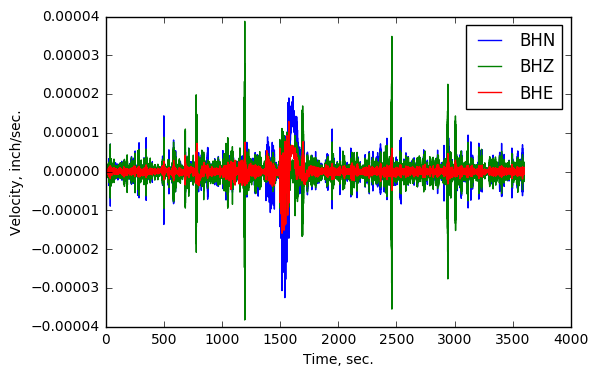

In [5]:
plt.plot(t,st_1[0].data/Cal, t,st_1[1].data/Cal, t,st_1[2].data/Cal)
plt.xlabel('Time, sec.')
plt.ylabel('Velocity, inch/sec.')
plt.legend([st_1[0].stats.channel ,st_1[1].stats.channel,st_1[2].stats.channel])
plt.show ()

## Declare valriables and functions for calculating and plotting transfer functions

In [6]:
# declare variables
fs = 100.0  # sampling rate
N = 2**12  # N is number of point
T = (N-1.0) / fs  # length of time in each data_set, second
xf = np.linspace(0.0, fs/2, N/2) # frequency array

N_Dir = [0, 1, 2, 1, 1] # list of channel data of North direction
E_Dir = [2, 0, 0, 2, 2] # list of channel data of East direction
V_Dir = [1, 2, 1, 0, 0] # list of channel data of Vertical direction

n_avg = int(len(st_1[2].data)/N)

# define data matrix size
data_set = np.zeros((5, n_avg, N)) # channel number, number of average, N point of data
Data_set = np.zeros((5, n_avg, int(N/2)), np.complex64) # FFT of data_set
Data_mean = np.zeros((5, int(N/2)), np.complex64) # Data average - channel number, N Pint of data
Tx_1 = np.zeros((5, n_avg, int(N/2)), np.complex64) # transfer function channel x to ch 1
Tx_1_mean = np.zeros((5, int(N/2)), np.complex64) # mean transfer function channel x to ch 1

In [12]:
def MovingAverage(x, N): #data = x, number of average = N
    wts = np.append(np.ones((1,))/N/2, np.ones((N,))/N)
    wts = np.append(wts, np.ones((1,))/N/2)
    return np.convolve(x, wts, mode='same') # same will return the same size of the data
def PlotFig(FigTitle):
    # Plot figures 
    fig=figure(num=1) #, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    fig.clf()
    #subplot(2,1,1), plot time record
    ax1=axes([0.1,0.57,0.8,0.35])
    for j in range (1, 3):  # channel 2 to channel 5

        plot(xf, np.absolute(Tx_1_mean[j, :]))


    #plot(xf, Y_MvAvg) #, 'o',ms=5, markeredgewidth=0.0)
    grid()
    #title(xlabel)
    xlim(0, 10)
    ylim(0, 20)
    xlabel ('Frequency, Hz',fontsize=14)
    ylabel ('Amplitude',fontsize=14)
    title(FigTitle)
    #legend(['west mid deck/ground', 'east mid deck/ground'])
    legend(['1_2', '1_3', '1_4', '1_5'])


    ax2=axes([0.1,0.1,0.8,0.35])
    #plot(xf, np.absolute(Data_mean[2, :])/np.pi*180, 'o' ,ms=3, markeredgewidth=0.0)

    for j in range (1, 3):  # channel 2 to channel 5
        if j != 0:
            plot(xf, np.angle(Tx_1_mean[j, :])/np.pi*180, 'o' ,ms=3, markeredgewidth=0.0)

    grid()
    xlim(0, 10)
    ylim(-200, 200)
    xlabel ('Frequency, Hz',fontsize=14)
    ylabel ('Phase, Degree',fontsize=14)
    show()

## North Direction

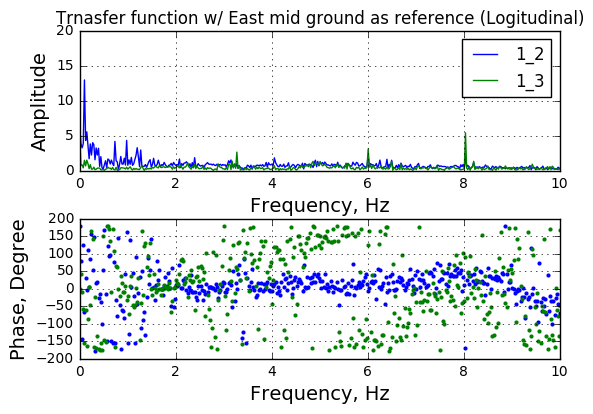

In [13]:
# North Direction
# 2. seperate data into size of N (default = 2**14) for average - obtain data_set
# 3. FFT data_set obtain Data_set
for j in range (0, 5):  # 5 channels of data
    for i in range (0, n_avg):  # n_avg of data_set
        data_set[j, i ,:] = st[j][N_Dir[j]].data[i*N:(i+1)*N]
        #print(st[j][N_Dir[j]].stats.station, st[j][N_Dir[j]].stats.channel,i)
        yf = fft(data_set[j, i ,:])
        Y = 2.0/N *(yf[0:int(N/2)])
        Data_set[j, i, :] = Y

# 5. Calculate Mean and transfer functions
for j in range (0, 5):  # 5 channels of data
    Data_mean[j, :] = np.mean(Data_set[j,:,:], 0)
    for i in range (0, n_avg):  # n_avg of data_set
        try:
            Tx_1[j, i, :] = Data_set[j, i, :] / Data_set[0, i, :] # ch1 is the 0 row
            #if j == 0:  # there is no need to calculate it 5 times
            #    T5_4[i,:] = Data_set[4, i, :] / Data_set[3, i, :]
        except:
            print (j, i)
            pass
            
    Tx_1_mean[j, :] = np.mean(Tx_1[j,:,:], 0)
PlotFig('Trnasfer function w/ East mid ground as reference (Logitudinal)')

## East Direction

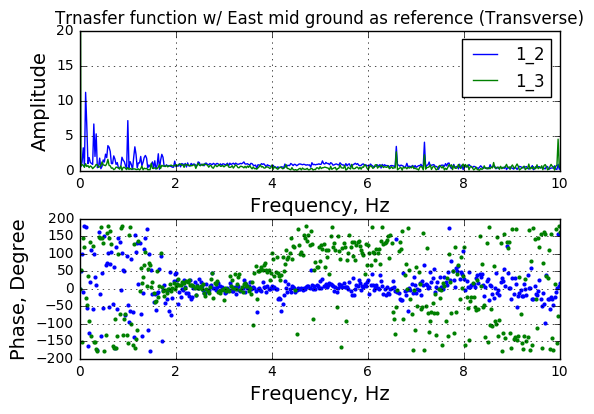

In [14]:
# East Direction
# 2. seperate data into size of N (default = 2**14) for average - obtain data_set
# 3. FFT data_set obtain Data_set
for j in range (0, 5):  # 5 channels of data
    for i in range (0, n_avg):  # n_avg of data_set
        data_set[j, i ,:] = st[j][E_Dir[j]].data[i*N:(i+1)*N]
        yf = fft(data_set[j, i ,:])
        Y = 2.0/N *(yf[0:int(N/2)])
        Data_set[j, i, :] = Y

# 5. Calculate Mean and transfer functions
for j in range (0, 5):  # 5 channels of data
    Data_mean[j, :] = np.mean(Data_set[j,:,:], 0)
    for i in range (0, n_avg):  # n_avg of data_set
        try:
            Tx_1[j, i, :] = Data_set[j, i, :] / Data_set[0, i, :] # ch1 is the 0 row
            #if j == 0:  # there is no need to calculate it 5 times
            #    T5_4[i,:] = Data_set[4, i, :] / Data_set[3, i, :]
        except:
            print (j, i)
            pass
            
    Tx_1_mean[j, :] = np.mean(Tx_1[j,:,:], 0)
PlotFig('Trnasfer function w/ East mid ground as reference (Transverse)')

## Vertical direction

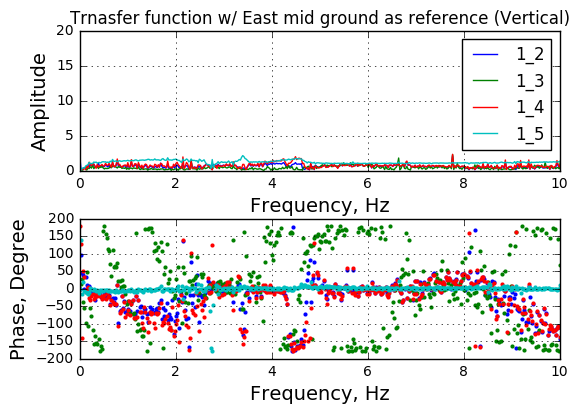

In [10]:
# Vertical Direction
# 2. seperate data into size of N (default = 2**14) for average - obtain data_set
# 3. FFT data_set obtain Data_set
for j in range (0, 5):  # 5 channels of data
    for i in range (0, n_avg):  # n_avg of data_set
        data_set[j, i ,:] = st[j][V_Dir[j]].data[i*N:(i+1)*N]
        yf = fft(data_set[j, i ,:])
        Y = 2.0/N *(yf[0:int(N/2)])
        Data_set[j, i, :] = Y

# 5. Calculate Mean and transfer functions
for j in range (0, 5):  # 5 channels of data
    Data_mean[j, :] = np.mean(Data_set[j,:,:], 0)
    for i in range (0, n_avg):  # n_avg of data_set
        try:
            Tx_1[j, i, :] = Data_set[j, i, :] / Data_set[0, i, :] # ch1 is the 0 row
            #if j == 0:  # there is no need to calculate it 5 times
            #    T5_4[i,:] = Data_set[4, i, :] / Data_set[3, i, :]
        except:
            print (j, i)
            pass
            
    Tx_1_mean[j, :] = np.mean(Tx_1[j,:,:], 0)
PlotFig('Trnasfer function w/ East mid ground as reference (Vertical)')

## H/V East mind deck

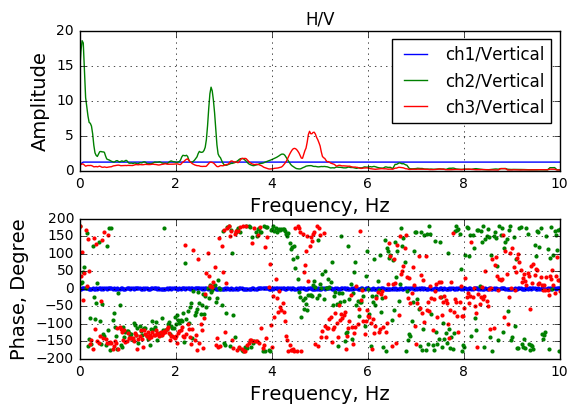

In [31]:
# H/V
# 2. seperate data into size of N (default = 2**14) for average - obtain data_set
# 3. FFT data_set obtain Data_set
Current_st = 4  # st[4] east brdige deck
for j in range (0, 3):  # 3 channels of data
    for i in range (0, n_avg):  # n_avg of data_set
        data_set[j, i ,:] = st[Current_st][j].data[i*N:(i+1)*N] 
        yf = fft(data_set[j, i ,:])
        Y = 2.0/N *(yf[0:int(N/2)])
        Data_set[j, i, :] = Y

# 5. Calculate Mean and transfer functions 
for j in range (0, 3):  # 3 channels of data
    Data_mean[j, :] = np.mean(Data_set[j,:,:], 0)
    for i in range (0, n_avg):  # n_avg of data_set
        try:
            Tx_1[j, i, :] = Data_set[j, i, :] / Data_set[V_Dir[Current_st], i, :] 
            # ch1 is Vertical in this sensor. Note: it may be different for other sensors
            # Ch1 is is the 0 row
        except:
            print (j, i)
            pass
            
    Tx_1_mean[j, :] = np.mean(Tx_1[j,:,:], 0)
    
# Plot figures 
fig=figure(num=1) #, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
fig.clf()
#subplot(2,1,1), plot time record
ax1=axes([0.1,0.57,0.8,0.35])
for j in range (0, 3):  # channel 1 to channel 3

    plot(xf, MovingAverage(np.absolute(Tx_1_mean[j, :]),5))

#plot(xf, Y_MvAvg) #, 'o',ms=5, markeredgewidth=0.0)
grid()
#title(xlabel)
xlim(0, 10)
#ylim(0, 50)
xlabel ('Frequency, Hz',fontsize=14)
ylabel ('Amplitude',fontsize=14)
title('H/V')
#legend(['west mid deck/ground', 'east mid deck/ground'])
legend(['ch1/Vertical', 'ch2/Vertical', 'ch3/Vertical'])


ax2=axes([0.1,0.1,0.8,0.35])
#plot(xf, np.absolute(Data_mean[2, :])/np.pi*180, 'o' ,ms=3, markeredgewidth=0.0)

for j in range (0, 3):  # channel 2 to channel 3
    plot(xf, np.angle(Tx_1_mean[j, :])/np.pi*180, 'o' ,ms=3, markeredgewidth=0.0)

grid()
xlim(0, 10)
ylim(-200, 200)
xlabel ('Frequency, Hz',fontsize=14)
ylabel ('Phase, Degree',fontsize=14)
show()